# Dynamic of Induction machine
This notebook simulates the dynamics of Induction machine. We will first define a dictionary for machine parameters. Next we will define a function which is the returns derivative function for the dynamics of the machine. 

In [1]:
# import autograd.numpy as np #numerical python - numpy array - search numpy 
import numpy as np #numerical python - numpy array - search numpy 
# from autograd.scipy.integrate import odeint #scipy - scientific python - linalg, integrate, signal
from scipy.integrate import odeint #scipy - scientific python - linalg, integrate, signal
from scipy import signal #
import matplotlib.pyplot as plt #
%matplotlib inline

### Defining Machine parameter as a dictionary

In [2]:
#Defining Machine parameters 

mach_mc = {"rs": 0.009, "rr": 0.007, "lh": 4.14, "ls": 4.21, "lr": 4.21, "tmech":509.6}

mach_mb = {"rs": 0.0185, "rr": 0.0132, "lh": 3.81, "ls": 3.9, "lr": 3.9, "tmech":397.31}

mach_ma = {"rs": 0.015, "rr": 0.04, "lh": 2.31, "ls": 2.35, "lr": 2.35, "tmech":596.9}

mach_BM = {"rs": 0.0426, "rr": 0.02113, "lh": 2.252, "ls": 2.252+0.078, "lr": 2.252+0.1052, "tmech":200.}


def mach_para(dict):
    rs = dict["rs"]
    rr = dict["rr"]
    lh = dict['lh']
    ls = dict['ls']
    lr = dict['lr']
    sig= 1-(lh*lh)/(lr*ls) # 
    kr=lh/lr #
    sigls=sig*ls
    tr=lr/rr
    rk=(rs+(kr)*(kr)*rr)
    tk=sigls/(rs+(kr)*(kr)*rr)
    tmech = dict['tmech']
#     print("lh = {0:1.3f}".format(lh))
    return rs,rr,lh,ls,lr,sig,kr,tr,rk,tk,tmech

rs,rr,lh,ls,lr,sig,kr,tr,rk,tk,tmech = mach_para(mach_mb)


#### Dynamic model of Induction Machine
To study the performance of Induction machine by simulation, we will need to develop the dynamic model of the induction machine that include the rotor inertia dynamics. We will choose 5 state variables. In effect, we are using only 3 state variables. However, out of the 3 state variables, the first 2 are complex state variables. Hence for simulation, we will decompose them into real and imaginary parts. These state variables as $i_{s\alpha}, i_{s,\beta}$,$\psi_{r,\alpha}, \psi_{r,\beta}$ and $\omega$. The differential equations are given as

\begin{align}
\frac{di_{s\alpha}}{d\tau}&= -\frac{1}{\tau_k}i_{s\alpha} + \frac{k_r}{\sigma l_s}\frac{1}{\tau_r}\psi_{r\alpha} + \frac{k_r}{\sigma ls}\omega\psi_{r\beta} + \frac{v_{s\alpha}}{\sigma ls}\\
\frac{di_{s\beta}}{d\tau}&= -\frac{1}{\tau_k}i_{s\beta} + \frac{k_r}{\sigma l_s}\frac{1}{\tau_r}\psi_{r\beta} - \frac{k_r}{\sigma ls}\omega\psi_{r\alpha} + \frac{v_{s\beta}}{\sigma ls}\\
\frac{d\psi_{r\alpha}}{d\tau}&= - \omega\psi_{r\beta} -\frac{1}{\tau_r}\psi_{r\alpha} +\frac{l_h}{\tau_r}i_{s\alpha}\\
\frac{d\psi_{r\beta}}{d\tau}&= \omega\psi_{r\alpha} -\frac{1}{\tau_r}\psi_{r\beta} +\frac{l_h}{\tau_r}i_{s\beta}\\
\frac{d\omega}{d\tau}&= \frac{1}{\tau_{mech}}\left[m_e - m_l\right]
\end{align}

### Converting dynamic equations at a partcular point into steady state
\begin{align}
\vec{v}_s &= r_s\vec{i}_s + \frac{d\vec{\psi}_s}{d\tau}\\
0 &= r_r\vec{i}_r + \frac{d\vec{\psi}_r}{d\tau} - j\omega\vec{\psi}_r \\
\frac{d\omega}{d\tau}&= \frac{1}{\tau_{mech}}\left[m_e - m_l\right]
\end{align}
becomes

\begin{align}
\vec{v}_s &= r_s\vec{i}_s + \frac{d|\psi_s|}{d\tau}e^{j\omega_s\tau} + j\omega_s\vec{\psi}_s\\
\end{align}
as the magnitue does not change, we get 
\begin{align}
\vec{v}_s &= r_s\vec{i}_s  + j\omega_s\vec{\psi}_s\\
\vec{v}_s &= r_s\vec{i}_s + j\omega_s(\sigma l_s\vec{i}_s + k_r\vec{\psi}_r) \\
\vec{v}_s &= r_s\vec{i}_s + j\omega_s\sigma l_s\vec{i}_s + j\omega_sk_r\vec{\psi}_r
\end{align}

Similarly rotor equation becomes
\begin{align}
0 &= r_r\vec{i}_r + \frac{d|\psi_r|e^{j\omega_s\tau}}{d\tau} - j\omega\vec{\psi}_r \\
0 &= r_r\vec{i}_r +  j\omega_r\vec{\psi}_r \\
0 &= \frac{r_r}{l_r}\left(\vec{\psi}_r - l_h\vec{i}_s \right) + j\omega_r\vec{\psi}_r \\
l_h\vec{i}_s &= (1 + j\omega_r\tau_r)\vec{\psi}_r
\end{align}

In rotor field coordinate system we can write the rotor equation as 

\begin{align}
l_h(i_{sd} + ji_{sq}) &= (1 + j\omega_r\tau_r)\psi_r \\
l_hi_{sd} &= \psi_r \\
l_hi_{sq}  &= \omega_r\tau_r\psi_r
\end{align}


In [3]:
def Im_dynamic(X,t,paraIM2):
    isa =X[0]
    isb = X[1]
    psira  = X[2]
    psirb  = X[3]
    w =      X[4]
    #paas on the machine parameters using params option
    vsa,vsb,ml,rs,rr,lh,ls,lr,sig,kr,tr,rk,tk,tmech  = paraIM2
    #
    me = kr*(psira*isb - psirb*isa) 
    #define the RHS of the ODE
    disadt = -(1/tk)*isa + (kr/(sig*ls*tr))*psira + (kr/(sig*ls))*w*psirb + vsa/(sig*ls)
    disbdt = -(1/tk)*isb + (kr/(sig*ls*tr))*psirb - (kr/(sig*ls))*w*psira + vsb/(sig*ls)
    dpsiradt = -w*psirb -(1/tr)*psira + (lh/tr)*isa
    dpsirbdt = +w*psira -(1/tr)*psirb + (lh/tr)*isb
    dwdt = (1/tmech)*(me - ml)
    return [disadt,disbdt,dpsiradt,dpsirbdt,dwdt]



In [4]:
def rotor_model(X,t,paramsmodel):
    psira = X[0]
    psirb = X[1]
    lh,tr,w,isa,isb =paramsmodel
    
    dpsiradt = -w*psirb -(1/tr)*psira + (lh/tr)*isa
    dpsirbdt = +w*psira -(1/tr)*psirb + (lh/tr)*isb
    return [dpsiradt,dpsirbdt]
    

In [5]:

tend = 500.0*2*np.pi # 2pi50*10 = 500*2pi  -- 10 50 hz cycles
tinc = 1e-2 #0.01
Tt1 = np.arange(0,tend,tinc) #defining the time series t = (starttime, endtime, timestep)

# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-3
w = 0.5  #initial rotor angular velocity = 0.2 
a = w    #a magnitude of voltage = w





#isalpha(0) = 0.3
#isbeta(0) = 0
#psira(0) = 1.0
#psirb(0) = 0.0
#w(0) = w

X0 = [0.3,0.0,0.0,0.0,0] #setting the inital conditions 
X0m = [0,0] 
u = np.zeros((len(Tt1),2)) #array for the voltage - u[0][0] - vsalpha(0) u[0][1] - vsbeta(0)
mla = np.zeros(len(Tt1))  #load torque array
soln = np.zeros((len(Tt1),5)) #array to store the solution values 
solm = np.zeros((len(Tt1),2))

#defining the voltage and torque steps
for ii,tn in enumerate(Tt1):
    if(Tt1[ii] < 0.1):
        u[ii] = [0,0]
        mla[ii] = 0.3
    elif(Tt1[ii] <= 300*2*np.pi):
        u[ii] = [a*np.cos(a*Tt1[ii]), a*np.sin(a*Tt1[ii])] #vbyf = constant acheived 
        mla[ii] = 0.3  #
    else:
        u[ii] = [a*np.cos(a*Tt1[ii]), a*np.sin(a*Tt1[ii])]
        mla[ii] = 1.0  #Torque changed to 1.0
#set machine parameters
rs,rr,lh,ls,lr,sig,kr,tr,rk,tk,tmech = mach_para(mach_mb)

#set for loop 
for ii,tn in enumerate(Tt1):
    
    params = [u[ii][0],u[ii][1],mla[ii],rs,rr,lh,ls,lr,sig,kr,tr,rk,tk,tmech] #desired frequency , voltage components, load torque
    #call odeint(dydt, Initial condition, [0,tinc], parameters)
    solx = odeint(Im_dynamic,X0, [0,tinc], args = (params,), atol = abserr, rtol = relerr)
    X0 = solx[-1] #
    soln[ii] = solx[-1] #
    # lh,tr,w,isa,isb
    #estimator uses only the variables that I can measure
    paramsmodel = [lh,tr*(0.5),soln[ii,4],soln[ii,0],soln[ii,1],]
    soly = odeint(rotor_model,X0m, [0,tinc], args = (paramsmodel,), atol = abserr, rtol = relerr)
    X0m = soly[-1]
    solm[ii] = soly[-1]
    

In [6]:
me1 = kr*(soln[:,2]*soln[:,1] - soln[:,3]*soln[:,0])

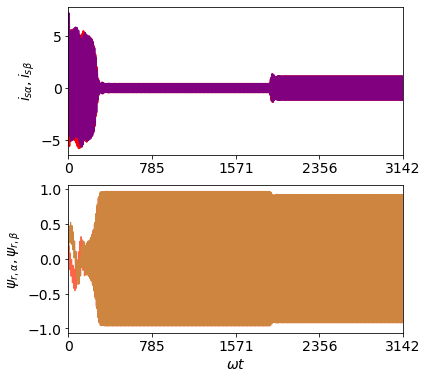

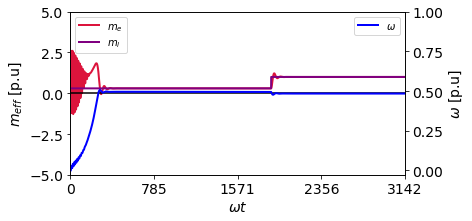

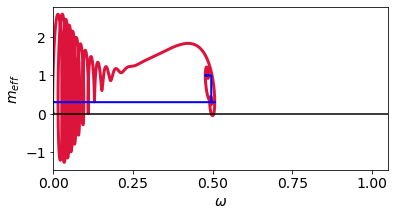

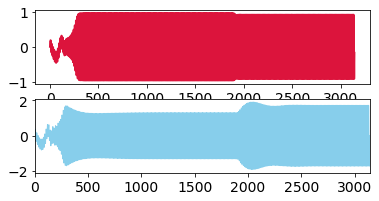

In [9]:
plt.figure(501, figsize = (6,6))
plt.rc('font', size = 14)
plt.subplot(2,1,1)
plt.plot(Tt1,  soln[:,0], 'r', lw=2)
plt.plot(Tt1,soln[:,1] ,'purple' ,lw =2)
plt.xlim(Tt1[0],Tt1[-1])
plt.ylabel(r'$i_{s\alpha}, i_{s\beta}$' )
plt.xticks(np.linspace(Tt1[0],Tt1[-1],5))
plt.subplot(2,1,2)
plt.plot(Tt1, soln[:,2], 'tomato', lw =1)
plt.plot(Tt1,soln[:,3], 'peru', lw =1)
plt.ylabel(r'$\psi_{r,\alpha}, \psi_{r,\beta}$' )
plt.xlabel(r'$\omega t$')
plt.xlim(Tt1[0],Tt1[-1])
plt.xticks(np.linspace(Tt1[0],Tt1[-1],5))

#pl.savefig('filenam1.pdf', bbox_inches = 'tight', transparent = True)
# pl.savefig('myfig.png', bbox_inches = 'tight', transparent = True)

plt.figure(602, figsize = (6,3))
ax1 = plt.subplot(1,1,1) 
ax1.plot(Tt1,me1, 'crimson', lw =2, label = '$m_e$')
ax1.plot(Tt1, mla, 'purple', lw =2, label = '$m_l$')
plt.axhline(0, c = 'k')
ax2 = ax1.twinx()
ax2.plot(Tt1,soln[:,4],'blue', lw =2, label = '$\omega$')
ax1.set_xlim(0,tend)
ax1.set_xticks(np.linspace(0,tend,5))
ax1.set_xlabel(r'$\omega t$')
ax1.set_ylabel('$m_{eff}$ [p.u]')
ax2.set_ylabel('$\omega$ [p.u]')
ax1.legend(loc = 'upper left', fontsize = 10)
ax2.legend(loc = 'upper right', fontsize = 10)

ax1.set_yticks(np.linspace(-5,5,5))
ax2.set_yticks(np.linspace(0,1.0,5))

#pl.savefig('filename.png', bbox_inches = 'tight', transparent = True)

plt.figure(612, figsize = (6,3))
plt.plot(soln[:,4],me1, 'crimson', lw =3)
plt.plot(soln[:,4],mla, 'blue', lw =2)
plt.xlabel(r'$\omega$')
plt.ylabel(r'$m_{eff}$')
plt.axhline(0,c='k')
plt.xticks(np.linspace(0,1.0,5))
plt.xlim(0,1.05)
#pl.savefig('filename.png', bbox_inches = 'tight', transparent = True)

plt.figure(613, figsize = (6,3))
plt.subplot(2,1,1)
plt.plot(Tt1,soln[:,2],'crimson',lw=2)
plt.subplot(2,1,2)
plt.plot(Tt1,solm[:,0], 'skyblue', lw=1)
plt.xlim(0,Tt1[-1])
plt.show()